# Goal: test remapping strategies

In [21]:
import sys
sys.path.append('../')

import numpy as np
from numpy.typing import NDArray
import scipy
from dataclasses import dataclass
from typing import Callable
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
import mpmath
import dill
import pickle
import os
import multiprocess as mp

from ray_delay.ray_detector import RayDetectorSpec, RayImpactSimulator
from stim_surface_code import patch, memory
from ray_delay.factory_simulator import Redundant15To1
from ray_delay.noise_model_patch import NoiseModelPatch
from ray_delay.noise_model import RayModelType, CosmicRayParams

import qc_utils.stats

mpmath.mp.dps = 50

In [49]:
dx = 7
dz = 3
dm = 3

f = Redundant15To1(dx, dz, dm, cache_cycles_per_distillation=True, mapping_mode='remap')
buffer_patch = memory.MemoryPatch(dx, dx, dm)
buffer_patch_n_qubits = len(buffer_patch.all_qubits)

1.0917691579943236


In [45]:
def get_buffer_size(radius):
    if radius >= 6:
        num_cycles = 1
    elif radius >= 4:
        num_cycles = 2
    elif radius >= 3:
        num_cycles = 3
    elif radius >= 2:
        num_cycles = 7
    else:
        num_cycles = 10
    return num_cycles

In [46]:
def expected_qubitcycle_overhead(ray_rate, recovery_time, online_chance, online_overhead, ray_radius):
    """Calculate the expected qubitcycle overhead for a given ray rate, recovery
    time, online chance, and online overhead. Assumes that more than one ray
    impact will always result in the factory being offline.
    
    Args:
        ray_rate: The rate of rays in Hz.
        recovery_time: The time it takes to recover from a ray in seconds.
        online_chance: The chance that the factory is online given a ray impact.
        online_overhead: The expected qubitcycle overhead, given that a factory
            is online, during a ray impact.
    
    Returns:
        The expected qubitcycle overhead.
    """
    qubit_overhead = 1 + get_buffer_size(ray_radius) * buffer_patch_n_qubits / f.num_phys_qubits

    prob_no_rays = scipy.stats.poisson.pmf(0, ray_rate*recovery_time)
    prob_1_ray = scipy.stats.poisson.pmf(1, ray_rate*recovery_time)

    # distillations per time, relative to no rays
    ts_per_time_relative = prob_no_rays + prob_1_ray*online_chance/online_overhead
    
    return qubit_overhead * 1/ts_per_time_relative

In [4]:
generate_specs = False

In [5]:
if generate_specs:
    radii = np.linspace(2, 7, 20)
    strengths = np.linspace(0.9, 1.0, 24)

    specs = []

    def get_spec(r, s):
        patch = NoiseModelPatch(memory.MemoryPatch(9, 9, 9))
        patch.noise_params.cosmic_ray_params.model = RayModelType.DIRECT
        patch.noise_params.cosmic_ray_params.min_radius = r
        patch.noise_params.cosmic_ray_params.max_radius = r
        patch.noise_params.cosmic_ray_params.max_strength = s

        sim = RayImpactSimulator(patch, spatial_window_size=2, only_full_windows=True)
        spec = sim.generate_detector_spec(window_fpr=mpmath.mpf(1e-13), cycles_per_distillation=18, decay_nsteps=1, save_detector_spec=True)
        return spec

    for r in radii:
        print(r)
        with mp.Pool(6) as pool:
            specs.append(pool.map((lambda strength: get_spec(r, strength)), strengths))

    with open('data/patch_ray_specs.pkl', 'wb') as f:
        dill.dump({
                'radii': radii,
                'strengths': strengths,
                'specs': specs
            }, 
            f
        )
else:
    with open('data/patch_ray_specs.pkl', 'rb') as f:
        data = dill.load(f)
        radii = data['radii']
        strengths = data['strengths']
        specs = data['specs']

In [ ]:
def get_ideal_detector_spec(radius, strength):
    return RayDetectorSpec(
        detector_spatial_window_size=None,
        detector_temporal_window_size=None,
        ray_params=CosmicRayParams(min_radius=radius, max_radius=radius, max_strength=strength),
        ideal_detection=True,
    )

def calc_overhead_ideal_detection(radius, strength):
    f = Redundant15To1(7, 3, 3, cache_cycles_per_distillation=True, mapping_mode='remap')
    spec = get_ideal_detector_spec(radius, strength)
    return f.calculate_avg_overhead_per_ray(spec)

In [8]:
f = Redundant15To1(7, 3, 3, cache_cycles_per_distillation=True, mapping_mode='remap')
assert len(f._cycles_per_distillation_cache) > 0 # make sure cache loaded

def calc_overhead(spec):
    return f.calculate_avg_overhead_per_ray(spec, 1000, 100, 1e-7, save_cache=False)

results = []

for i,r in enumerate(radii):
    print(i)
    with mp.Pool(6) as pool:
        results.append(pool.map(calc_overhead, specs[i]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [9]:
overheads = np.array([[r[0] for r in row] for row in results])
offline_rates = np.array([[r[1] for r in row] for row in results])

with open('data/evaluation_.pkl', 'wb') as f:
    dill.dump({
        'radii': radii,
        'strengths': strengths,
        'overheads': overheads,
        'offline_rates': offline_rates
    }, f)


In [50]:
no_remap_overheads = np.zeros_like(overheads)
net_overheads = np.zeros_like(overheads)
for i,r in enumerate(radii):
    for j,s in enumerate(strengths):
        no_remap_overheads[i,j] = expected_qubitcycle_overhead(1/27/10*f.num_phys_qubits, 50e-3, 0, 1, r)
        net_overheads[i,j] = expected_qubitcycle_overhead(1/27/10*f.num_phys_qubits, 50e-3, 1-offline_rates[i,j], overheads[i,j], r)

In [23]:
expected_qubitcycle_overhead(1/27/10*f.num_phys_qubits, 50e-3, 0, 1)

1.3278222602697765

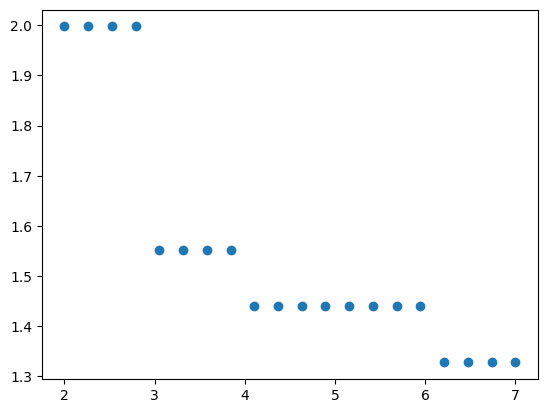

In [55]:
s_idx = -3
plt.plot(radii, no_remap_overheads[:,s_idx], 'o', label='No remap')

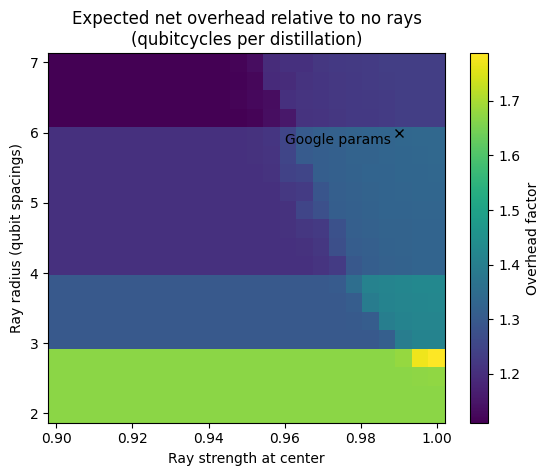

In [53]:
x, y = np.meshgrid(strengths, radii)
# cs = plt.contourf(x, y, net_overheads, levels=16)
# color_bounds = np.linspace(1, no_remap_overheads.max(), 10)
# norm = mpl.colors.BoundaryNorm(boundaries=color_bounds, ncolors=256)
cs = plt.pcolormesh(x, y, net_overheads)
# plt.imshow(net_overheads, origin='lower', extent=(strengths[0], strengths[-1], radii[0], radii[-1]), aspect='auto')
cbar = plt.colorbar(cs, label='Overhead factor')
# cbar.set_ticks(color_bounds)
plt.plot([0.99], [6], 'x', color='k')
plt.text(0.988, 6, 'Google params', color='k', ha='right', va='top')
plt.xlabel(r'Ray strength at center')
plt.ylabel(r'Ray radius (qubit spacings)')
plt.title('Expected net overhead relative to no rays\n(qubitcycles per distillation)')
plt.savefig('../figures/remap_radius_strength_overhead.svg', bbox_inches='tight')
plt.show()

In [25]:
selected_radius_idx = 2 #-4
selected_strength_idx = 2 #-3

online_rate = offline_rates[selected_radius_idx][selected_strength_idx]
online_overhead = overheads[selected_radius_idx,selected_strength_idx]

decay_times = np.linspace(0, 100e-3, 100)
ray_rates = np.linspace(0, 1/27/10*f.num_phys_qubits*1.1, 99)

no_remap_overheads = np.zeros((len(decay_times), len(ray_rates)))
rate_overheads = np.zeros((len(decay_times), len(ray_rates)))
for i,decay_time in enumerate(decay_times):
    for j,ray_rate in enumerate(ray_rates):
        no_remap_overheads[i,j] = expected_qubitcycle_overhead(ray_rate, decay_time, 0, 1)
        rate_overheads[i,j] = expected_qubitcycle_overhead(ray_rate, decay_time, online_rate, online_overhead)

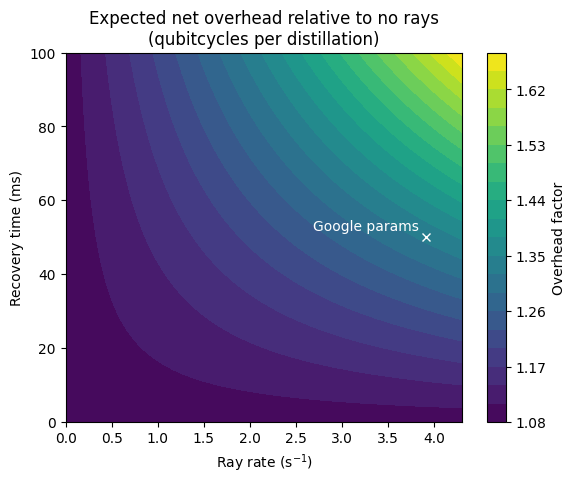

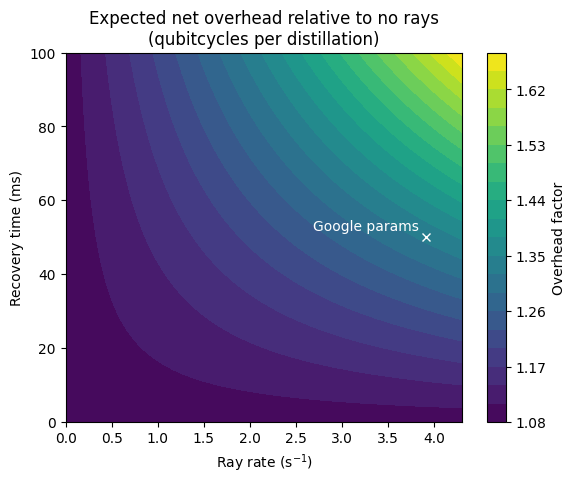

In [26]:
x, y = np.meshgrid(ray_rates, decay_times*1e3)
cs = plt.contourf(x, y, no_remap_overheads, levels=20)
plt.plot([1/27/10*f.num_phys_qubits], [50], 'x', color='w')

plt.text(1/27/10*f.num_phys_qubits * 0.98, 50*1.02, 'Google params', ha='right', va='bottom', color='w')
# plt.text(1/27/10*f.num_phys_qubits * 0.7, 50 * 1.05, 'Google params', color='w')
plt.colorbar(cs, label='Overhead factor')
plt.xlabel(r'Ray rate (s$^{-1}$)') 
plt.ylabel(r'Recovery time (ms)')
plt.title('Expected net overhead relative to no rays\n(qubitcycles per distillation)')
plt.savefig('../figures/remap_rate_decay_overhead.svg', bbox_inches='tight')
plt.show()

x, y = np.meshgrid(ray_rates, decay_times*1e3)
cs = plt.contourf(x, y, rate_overheads, levels=20)
plt.plot([1/27/10*f.num_phys_qubits], [50], 'x', color='w')

plt.text(1/27/10*f.num_phys_qubits * 0.98, 50*1.02, 'Google params', ha='right', va='bottom', color='w')
# plt.text(1/27/10*f.num_phys_qubits * 0.7, 50 * 1.05, 'Google params', color='w')
plt.colorbar(cs, label='Overhead factor')
plt.xlabel(r'Ray rate (s$^{-1}$)') 
plt.ylabel(r'Recovery time (ms)')
plt.title('Expected net overhead relative to no rays\n(qubitcycles per distillation)')
plt.savefig('../figures/remap_rate_decay_overhead.svg', bbox_inches='tight')
plt.show()